# Stochastic Gradient Descent with Learning Rate Schedules and Regularization

## Imports

In [1]:
import numpy as np
from sklearn.model_selection import *
from src.data import *
from src.helpers import test_model_performance, plot_performance_metrics

## Structure of SGD

In [2]:
class SGD:
    """Стохастический градиентный спуск для задач регрессии."""

    def __init__(self, learning_rate=0.01, epochs=100, batch_size=32,
                 regularization=None, reg_param=0.01, lr_schedule=None,
                 momentum=0.0, early_stopping=False, patience=10,
                 verbose=False, random_state=None):
        """
        Инициализация SGD с настройками

        Параметры:
        learning_rate : начальная скорость обучения
        epochs : количество эпох обучения
        batch_size : размер мини-батча
        regularization : тип регуляризации ('l1', 'l2', 'elasticnet')
        reg_param : параметр регуляризации (lambda)
        lr_schedule : график скорости обучения ('constant', 'time_decay', 'step_decay', 'exponential')
        momentum : коэффициент импульса (0 - без импульса)
        early_stopping : использовать раннюю остановку
        patience : количество эпох без улучшения для ранней остановки
        verbose : выводить информацию о процессе обучения
        random_state : значение для воспроизводимости результатов
        """
        self.learning_rate = learning_rate
        self.epochs = epochs
        self.batch_size = batch_size
        self.regularization = regularization
        self.reg_param = reg_param
        self.lr_schedule = lr_schedule
        self.momentum = momentum
        self.early_stopping = early_stopping
        self.patience = patience
        self.verbose = verbose

        self.random_state = random_state
        self.rng = np.random.RandomState(random_state)

        self.weights = None
        self.bias = None
        self.velocity_w = None
        self.velocity_b = None

        self.loss_history = []
        self.val_loss_history = []
        self.best_weights = None
        self.best_bias = None
        self.best_val_loss = float('inf')
        self.best_epoch = 0

    def _initialize_parameters(self, n_features):
        """Инициализация весов и смещения"""
        # Инициализация Xavier для лучшей сходимости
        limit = np.sqrt(6 / (n_features + 1))
        self.weights = self.rng.uniform(-limit, limit, n_features)
        self.bias = 0.0

        # Инициализация для импульса
        self.velocity_w = np.zeros(n_features)
        self.velocity_b = 0.0

        # Для early stopping
        self.best_weights = self.weights.copy()
        self.best_bias = self.bias

    def _get_learning_rate(self, epoch):
        """Расчет скорости обучения в зависимости от графика"""
        if self.lr_schedule is None or self.lr_schedule == 'constant':
            return self.learning_rate

        if self.lr_schedule == 'time_decay':
            decay_rate = 0.01
            return self.learning_rate / (1 + decay_rate * epoch)

        if self.lr_schedule == 'step_decay':
            drop = 0.5
            epochs_drop = 10
            return self.learning_rate * np.power(drop, np.floor(epoch / epochs_drop))

        if self.lr_schedule == 'exponential':
            decay_rate = 0.01
            return self.learning_rate * np.exp(-decay_rate * epoch)

        return self.learning_rate

    def _apply_regularization(self, weights, gradient):
        """Применение регуляризации к градиенту"""
        if self.regularization is None:
            return gradient

        if self.regularization == 'l2':
            return gradient + self.reg_param * weights

        if self.regularization == 'l1':
            return gradient + self.reg_param * np.sign(weights)

        if self.regularization == 'elasticnet':
            l1_ratio = 0.5
            l1_contrib = self.reg_param * l1_ratio * np.sign(weights)
            l2_contrib = self.reg_param * (1 - l1_ratio) * weights
            return gradient + l1_contrib + l2_contrib

        return gradient

    def _compute_gradient(self, X_batch, y_batch):
        """Вычисление градиента для мини-батча"""
        m = X_batch.shape[0]
        predictions = X_batch @ self.weights + self.bias  # оптимизировано
        errors = predictions - y_batch

        # Оптимизированное вычисление градиента
        dw = (X_batch.T @ errors) / m
        db = np.mean(errors)

        # Применение регуляризации только к весам
        dw = self._apply_regularization(self.weights, dw)

        return dw, db

    def fit(self, X, y, X_val=None, y_val=None):
        """
        Обучение модели на данных
        """
        X = np.asarray(X)
        y = np.asarray(y)

        if X_val is not None:
            X_val = np.asarray(X_val)
            y_val = np.asarray(y_val)
            use_validation = True
        else:
            use_validation = False

        n_samples, n_features = X.shape
        self._initialize_parameters(n_features)

        self.loss_history = []
        self.val_loss_history = []
        no_improvement_count = 0

        for epoch in range(self.epochs):
            # Перемешиваем данные на каждой эпохе
            indices = self.rng.permutation(n_samples)
            X_shuffled = X[indices]
            y_shuffled = y[indices]

            # Текущая скорость обучения
            current_lr = self._get_learning_rate(epoch)

            # Мини-батч SGD
            for i in range(0, n_samples, self.batch_size):
                end_idx = min(i + self.batch_size, n_samples)
                X_batch = X_shuffled[i:end_idx]
                y_batch = y_shuffled[i:end_idx]

                # Вычисление градиентов
                dw, db = self._compute_gradient(X_batch, y_batch)

                # Обновление с использованием импульса
                self.velocity_w = self.momentum * self.velocity_w - current_lr * dw
                self.velocity_b = self.momentum * self.velocity_b - current_lr * db

                # Обновление параметров
                self.weights += self.velocity_w
                self.bias += self.velocity_b

            # Расчет ошибки на обучающей выборке
            train_predictions = X @ self.weights + self.bias
            train_loss = np.mean((train_predictions - y) ** 2)
            self.loss_history.append(train_loss)

            # Расчет ошибки на валидационной выборке
            if use_validation:
                val_predictions = X_val @ self.weights + self.bias
                val_loss = np.mean((val_predictions - y_val) ** 2)
                self.val_loss_history.append(val_loss)

                # Сохраняем лучшие веса
                if val_loss < self.best_val_loss:
                    self.best_val_loss = val_loss
                    self.best_weights = self.weights.copy()
                    self.best_bias = self.bias
                    self.best_epoch = epoch
                    no_improvement_count = 0
                else:
                    no_improvement_count += 1

            # Вывод прогресса
            if self.verbose and (epoch + 1) % 10 == 0:
                status = f"Эпоха {epoch + 1}/{self.epochs}, loss: {train_loss:.6f}"
                if use_validation:
                    status += f", val_loss: {val_loss:.6f}"
                print(status)

            # Ранняя остановка
            if self.early_stopping and use_validation and no_improvement_count >= self.patience:
                if self.verbose:
                    print(f"Ранняя остановка на эпохе {epoch + 1}")
                # Восстанавливаем лучшие веса
                self.weights = self.best_weights
                self.bias = self.best_bias
                break

        # Восстанавливаем лучшие веса в конце обучения
        if use_validation:
            self.weights = self.best_weights
            self.bias = self.best_bias

        return self

    def predict(self, X):
        """Выполнение прогноза"""
        X = np.asarray(X)
        return X @ self.weights + self.bias

[I 2025-05-21 18:06:41,695] A new study created in memory with name: SGD_reg-l1_lr-0.01_schedule-constant_lambda-0.01


  0%|          | 0/8 [00:00<?, ?it/s]

[I 2025-05-21 18:06:42,119] Trial 2 finished with value: 0.5451785997224803 and parameters: {}. Best is trial 2 with value: 0.5451785997224803.
[I 2025-05-21 18:06:42,216] Trial 1 finished with value: 993.8314898164475 and parameters: {}. Best is trial 2 with value: 0.5451785997224803.
[I 2025-05-21 18:06:42,235] Trial 4 finished with value: 0.5613665970514273 and parameters: {}. Best is trial 2 with value: 0.5451785997224803.
[I 2025-05-21 18:06:42,279] Trial 5 finished with value: 0.5511799057083722 and parameters: {}. Best is trial 2 with value: 0.5451785997224803.
[I 2025-05-21 18:06:42,345] Trial 3 finished with value: 0.5498470659659752 and parameters: {}. Best is trial 2 with value: 0.5451785997224803.
[I 2025-05-21 18:06:42,634] Trial 7 finished with value: 0.8064910994678149 and parameters: {}. Best is trial 2 with value: 0.5451785997224803.
[I 2025-05-21 18:06:42,701] Trial 6 finished with value: 0.5984212743801647 and parameters: {}. Best is trial 2 with value: 0.54517859972

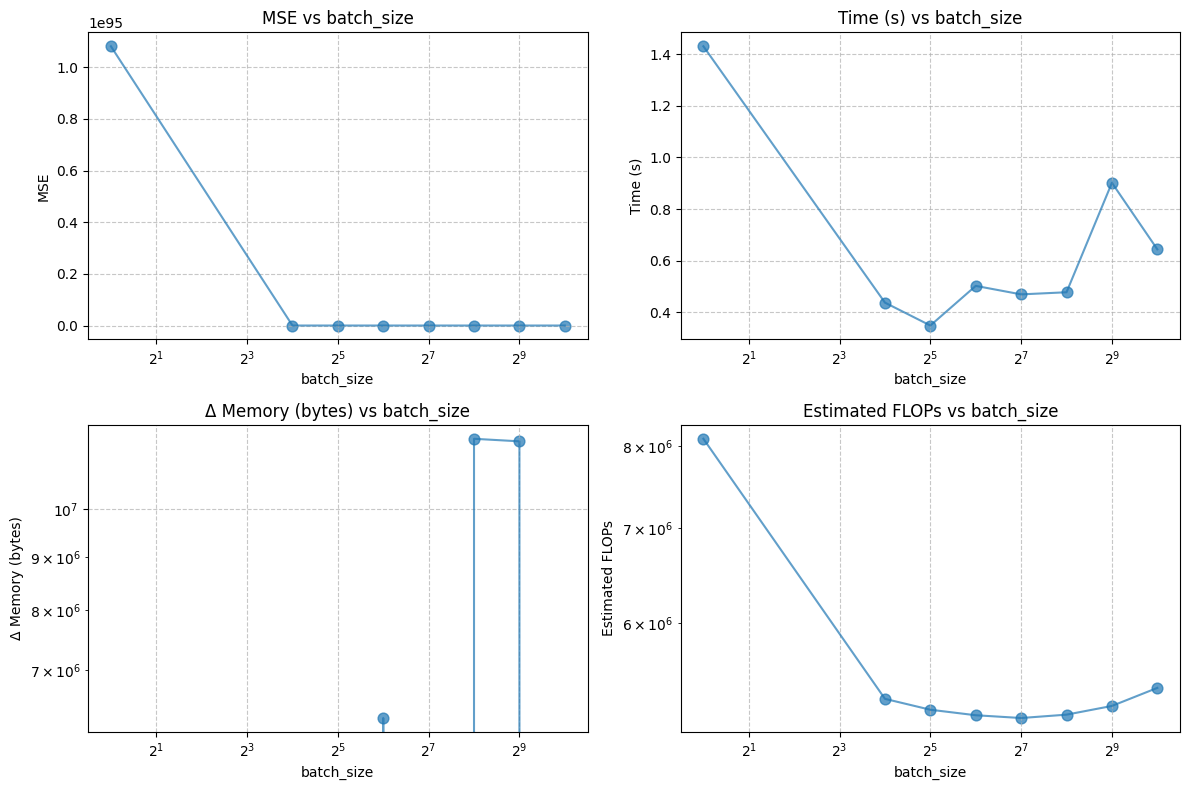

[I 2025-05-21 18:06:45,224] A new study created in memory with name: SGD_reg-l1_lr-0.01_schedule-time_decay_lambda-0.01


  0%|          | 0/8 [00:00<?, ?it/s]

[I 2025-05-21 18:06:45,742] Trial 1 finished with value: 1979.2883495187364 and parameters: {}. Best is trial 1 with value: 1979.2883495187364.
[I 2025-05-21 18:06:45,751] Trial 4 finished with value: 0.5649204997143348 and parameters: {}. Best is trial 4 with value: 0.5649204997143348.
[I 2025-05-21 18:06:45,751] Trial 3 finished with value: 0.5465822418831552 and parameters: {}. Best is trial 3 with value: 0.5465822418831552.
[I 2025-05-21 18:06:45,811] Trial 2 finished with value: 0.5498040555039773 and parameters: {}. Best is trial 3 with value: 0.5465822418831552.
[I 2025-05-21 18:06:45,848] Trial 5 finished with value: 0.5804554136957771 and parameters: {}. Best is trial 3 with value: 0.5465822418831552.
[I 2025-05-21 18:06:46,203] Trial 7 finished with value: 0.8286791599071396 and parameters: {}. Best is trial 3 with value: 0.5465822418831552.
[I 2025-05-21 18:06:46,282] Trial 6 finished with value: 0.690890650946293 and parameters: {}. Best is trial 3 with value: 0.54658224188

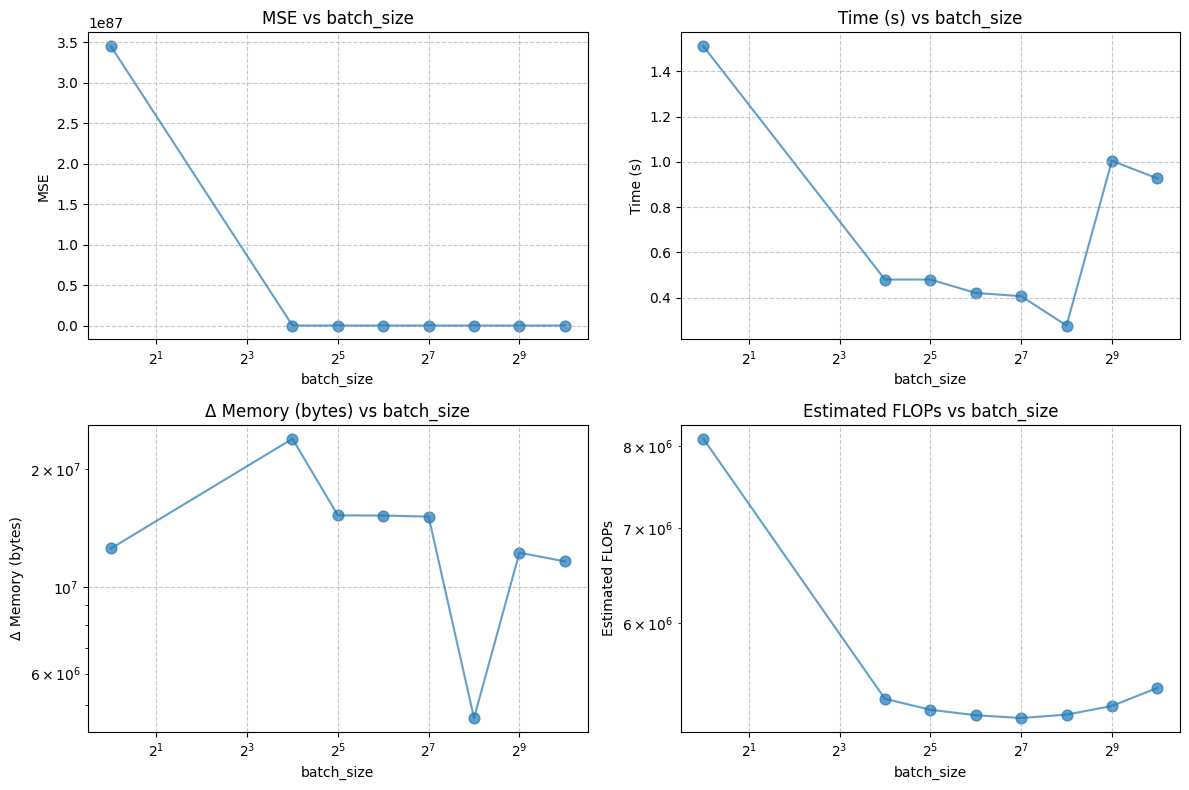

[I 2025-05-21 18:06:48,629] A new study created in memory with name: SGD_reg-l1_lr-0.01_schedule-step_decay_lambda-0.01


  0%|          | 0/8 [00:00<?, ?it/s]

[I 2025-05-21 18:06:49,252] Trial 2 finished with value: 0.5409154681712605 and parameters: {}. Best is trial 2 with value: 0.5409154681712605.
[I 2025-05-21 18:06:49,280] Trial 3 finished with value: 0.5523935082808309 and parameters: {}. Best is trial 2 with value: 0.5409154681712605.
[I 2025-05-21 18:06:49,344] Trial 5 finished with value: 0.6131876016824748 and parameters: {}. Best is trial 2 with value: 0.5409154681712605.
[I 2025-05-21 18:06:49,351] Trial 1 finished with value: 4814.85125233245 and parameters: {}. Best is trial 2 with value: 0.5409154681712605.
[I 2025-05-21 18:06:49,375] Trial 4 finished with value: 0.5640363983525759 and parameters: {}. Best is trial 2 with value: 0.5409154681712605.
[I 2025-05-21 18:06:49,681] Trial 7 finished with value: 0.8032812548337508 and parameters: {}. Best is trial 2 with value: 0.5409154681712605.
[I 2025-05-21 18:06:49,786] Trial 6 finished with value: 0.6323361608410615 and parameters: {}. Best is trial 2 with value: 0.540915468171

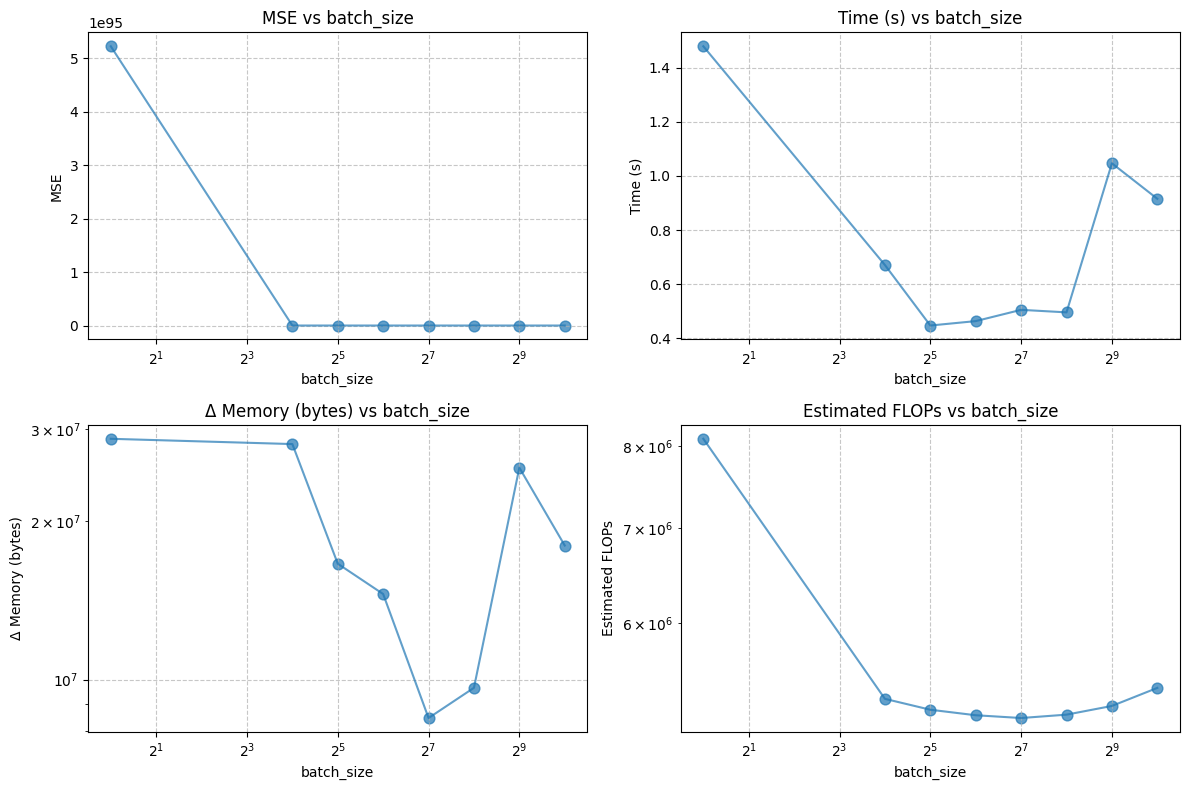

[I 2025-05-21 18:06:51,897] A new study created in memory with name: SGD_reg-l1_lr-0.01_schedule-exponential_lambda-0.01


  0%|          | 0/8 [00:00<?, ?it/s]

[I 2025-05-21 18:06:52,292] Trial 5 finished with value: 0.5698804174215537 and parameters: {}. Best is trial 5 with value: 0.5698804174215537.
[I 2025-05-21 18:06:52,364] Trial 2 finished with value: 0.5448939028606355 and parameters: {}. Best is trial 2 with value: 0.5448939028606355.
[I 2025-05-21 18:06:52,429] Trial 4 finished with value: 0.5874946488563646 and parameters: {}. Best is trial 2 with value: 0.5448939028606355.
[I 2025-05-21 18:06:52,526] Trial 3 finished with value: 0.5537775539199572 and parameters: {}. Best is trial 2 with value: 0.5448939028606355.
[I 2025-05-21 18:06:52,552] Trial 1 finished with value: 6.099477794429232 and parameters: {}. Best is trial 2 with value: 0.5448939028606355.
[I 2025-05-21 18:06:52,989] Trial 6 finished with value: 0.6446419671191698 and parameters: {}. Best is trial 2 with value: 0.5448939028606355.
[I 2025-05-21 18:06:53,035] Trial 7 finished with value: 0.8644813718427139 and parameters: {}. Best is trial 2 with value: 0.54489390286

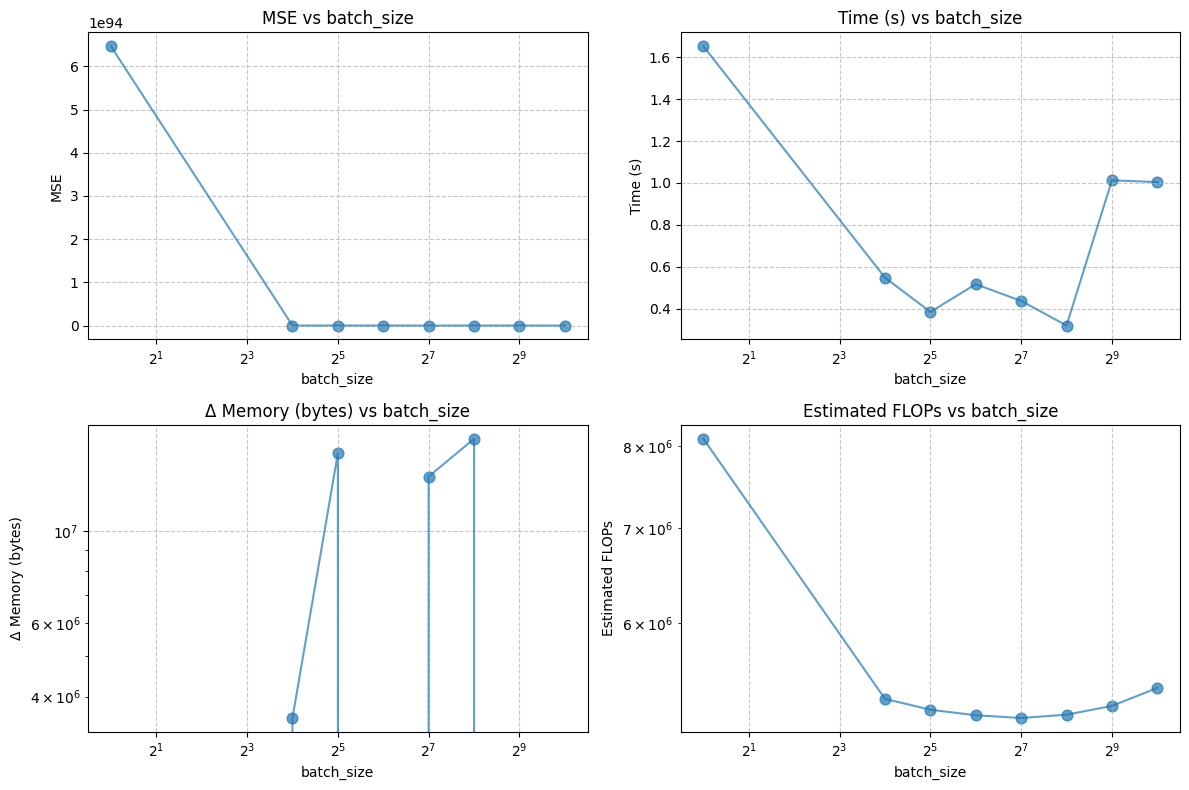

[I 2025-05-21 18:06:55,535] A new study created in memory with name: SGD_reg-l2_lr-0.01_schedule-constant_lambda-0.01


  0%|          | 0/8 [00:00<?, ?it/s]

[I 2025-05-21 18:06:55,696] Trial 5 finished with value: 0.6248321612342198 and parameters: {}. Best is trial 5 with value: 0.6248321612342198.
[I 2025-05-21 18:06:55,938] Trial 3 finished with value: 0.5494453195584305 and parameters: {}. Best is trial 3 with value: 0.5494453195584305.
[I 2025-05-21 18:06:55,944] Trial 4 finished with value: 0.5798602168782664 and parameters: {}. Best is trial 3 with value: 0.5494453195584305.
[I 2025-05-21 18:06:56,131] Trial 2 finished with value: 0.5467559223507866 and parameters: {}. Best is trial 2 with value: 0.5467559223507866.
[I 2025-05-21 18:06:56,270] Trial 1 finished with value: 33689.05320244771 and parameters: {}. Best is trial 2 with value: 0.5467559223507866.
[I 2025-05-21 18:06:56,285] Trial 7 finished with value: 0.7774926729928778 and parameters: {}. Best is trial 2 with value: 0.5467559223507866.
[I 2025-05-21 18:06:56,370] Trial 6 finished with value: 0.5659531083780107 and parameters: {}. Best is trial 2 with value: 0.54675592235

/Users/aleksandr/Desktop/itmo/s4/optimisation-methods/Stochastic-Gradient-Descent/src/helpers.py:289: UserWarning: Data has no positive values, and therefore cannot be log-scaled.
  ax.set_yscale("log")


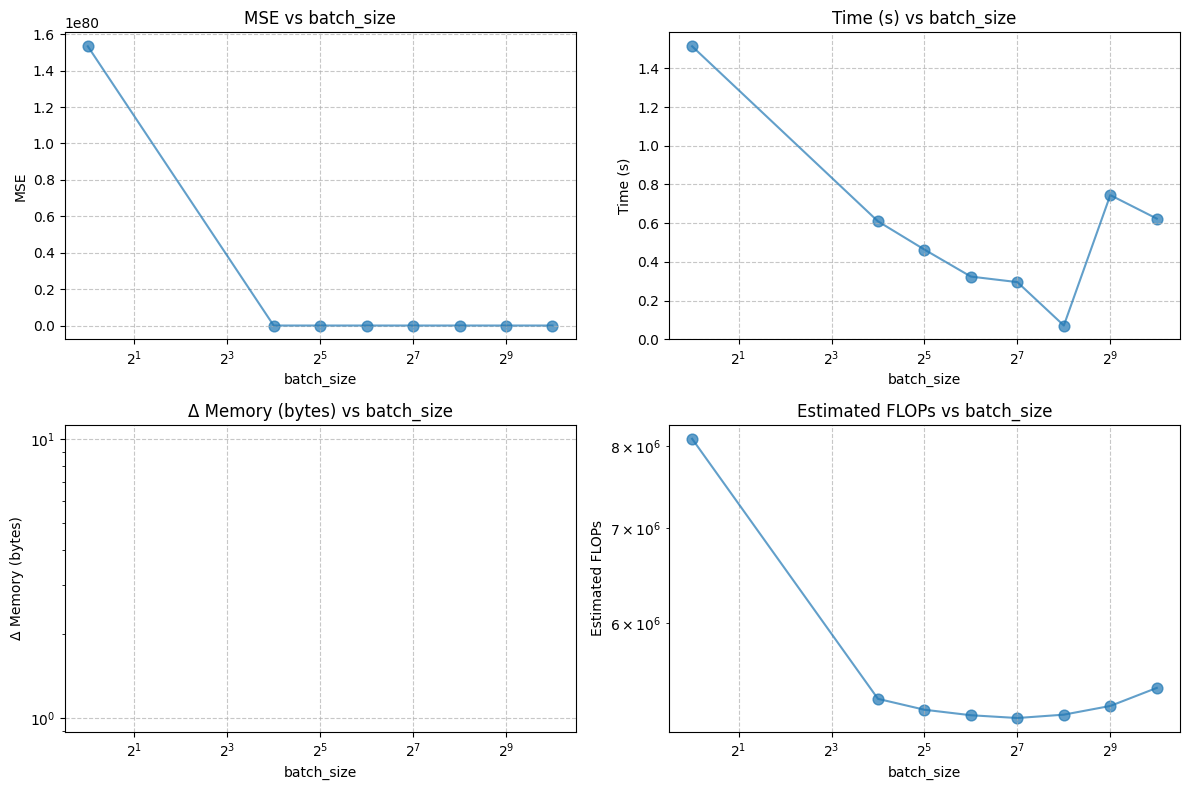

[I 2025-05-21 18:06:58,898] A new study created in memory with name: SGD_reg-l2_lr-0.01_schedule-time_decay_lambda-0.01


  0%|          | 0/8 [00:00<?, ?it/s]

[I 2025-05-21 18:06:59,180] Trial 2 finished with value: 0.546839294017493 and parameters: {}. Best is trial 2 with value: 0.546839294017493.
[I 2025-05-21 18:06:59,322] Trial 5 finished with value: 0.6014096207721168 and parameters: {}. Best is trial 2 with value: 0.546839294017493.
[I 2025-05-21 18:06:59,335] Trial 3 finished with value: 0.5559704840013534 and parameters: {}. Best is trial 2 with value: 0.546839294017493.
[I 2025-05-21 18:06:59,377] Trial 1 finished with value: 11.289992707630587 and parameters: {}. Best is trial 2 with value: 0.546839294017493.
[I 2025-05-21 18:06:59,482] Trial 4 finished with value: 0.5718683508352816 and parameters: {}. Best is trial 2 with value: 0.546839294017493.
[I 2025-05-21 18:06:59,862] Trial 7 finished with value: 0.9321214627151869 and parameters: {}. Best is trial 2 with value: 0.546839294017493.
[I 2025-05-21 18:06:59,876] Trial 6 finished with value: 0.7111237681944658 and parameters: {}. Best is trial 2 with value: 0.546839294017493.


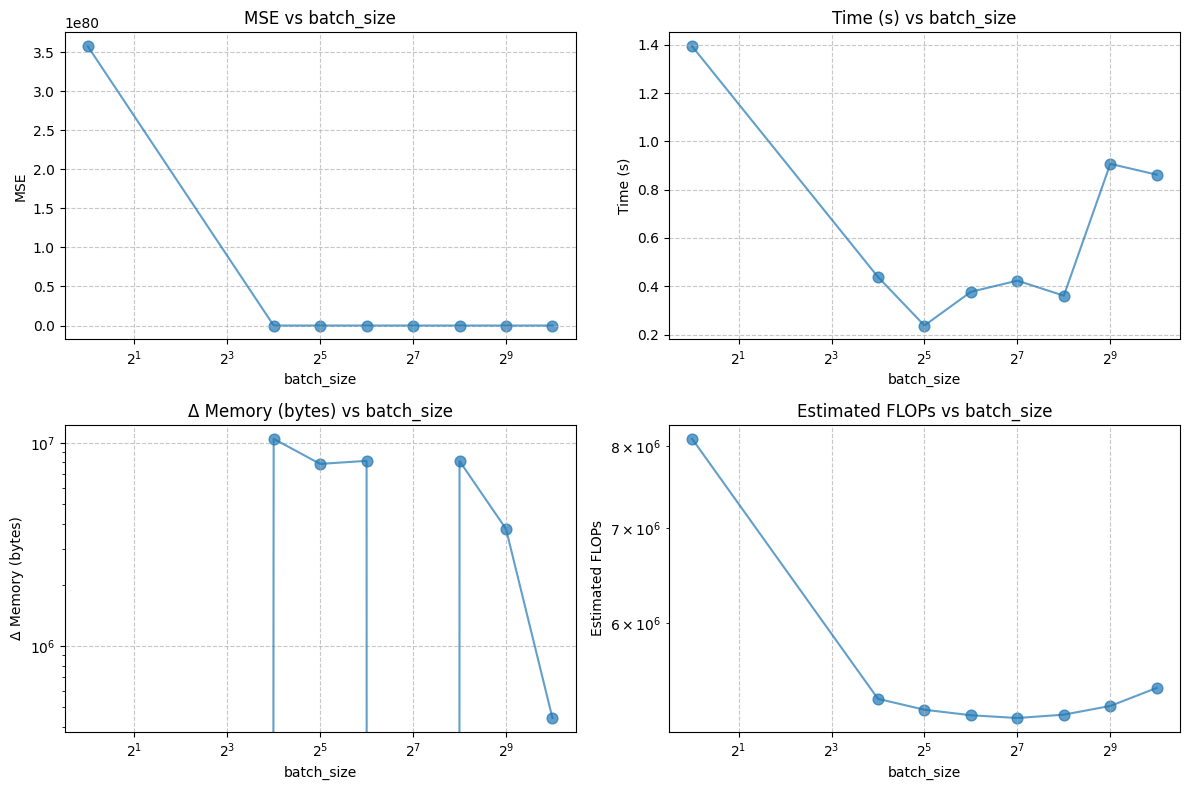

[I 2025-05-21 18:07:02,047] A new study created in memory with name: SGD_reg-l2_lr-0.01_schedule-step_decay_lambda-0.01


  0%|          | 0/8 [00:00<?, ?it/s]

[I 2025-05-21 18:07:02,480] Trial 2 finished with value: 0.5497801329718899 and parameters: {}. Best is trial 2 with value: 0.5497801329718899.
[I 2025-05-21 18:07:02,566] Trial 4 finished with value: 0.5565144308163207 and parameters: {}. Best is trial 2 with value: 0.5497801329718899.
[I 2025-05-21 18:07:02,591] Trial 1 finished with value: 101567.38160107358 and parameters: {}. Best is trial 2 with value: 0.5497801329718899.
[I 2025-05-21 18:07:02,617] Trial 5 finished with value: 0.5650941278159902 and parameters: {}. Best is trial 2 with value: 0.5497801329718899.
[I 2025-05-21 18:07:02,630] Trial 3 finished with value: 0.561094118829863 and parameters: {}. Best is trial 2 with value: 0.5497801329718899.
[I 2025-05-21 18:07:03,078] Trial 6 finished with value: 0.670856206769617 and parameters: {}. Best is trial 2 with value: 0.5497801329718899.
[I 2025-05-21 18:07:03,104] Trial 7 finished with value: 0.8702685920546593 and parameters: {}. Best is trial 2 with value: 0.549780132971

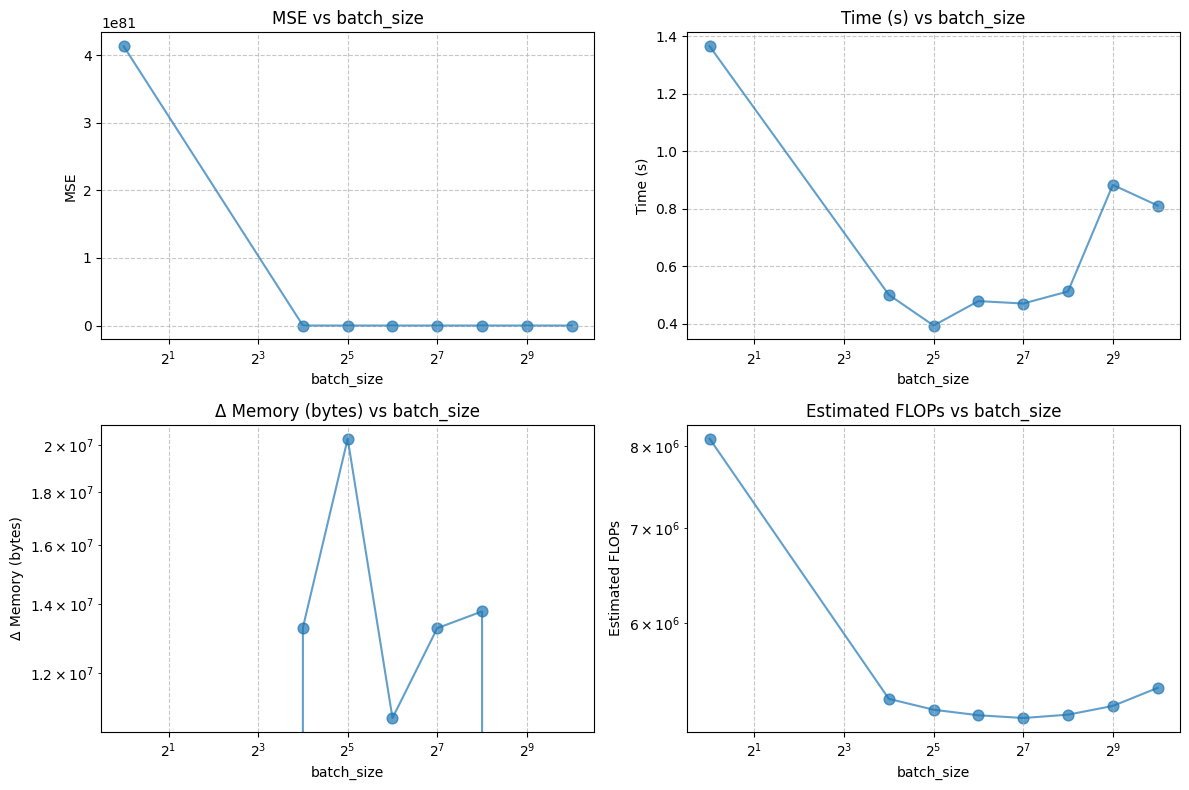

[I 2025-05-21 18:07:05,200] A new study created in memory with name: SGD_reg-l2_lr-0.01_schedule-exponential_lambda-0.01


  0%|          | 0/8 [00:00<?, ?it/s]

[I 2025-05-21 18:07:05,557] Trial 2 finished with value: 0.5530796951006647 and parameters: {}. Best is trial 2 with value: 0.5530796951006647.
[I 2025-05-21 18:07:05,590] Trial 5 finished with value: 0.561763796285901 and parameters: {}. Best is trial 2 with value: 0.5530796951006647.
[I 2025-05-21 18:07:05,726] Trial 3 finished with value: 0.5531490854258613 and parameters: {}. Best is trial 2 with value: 0.5530796951006647.
[I 2025-05-21 18:07:05,732] Trial 1 finished with value: 147.67839750391133 and parameters: {}. Best is trial 2 with value: 0.5530796951006647.
[I 2025-05-21 18:07:05,817] Trial 4 finished with value: 0.5721876299982499 and parameters: {}. Best is trial 2 with value: 0.5530796951006647.
[I 2025-05-21 18:07:06,035] Trial 7 finished with value: 0.8533439588821885 and parameters: {}. Best is trial 2 with value: 0.5530796951006647.
[I 2025-05-21 18:07:06,153] Trial 6 finished with value: 0.7198002882336749 and parameters: {}. Best is trial 2 with value: 0.55307969510

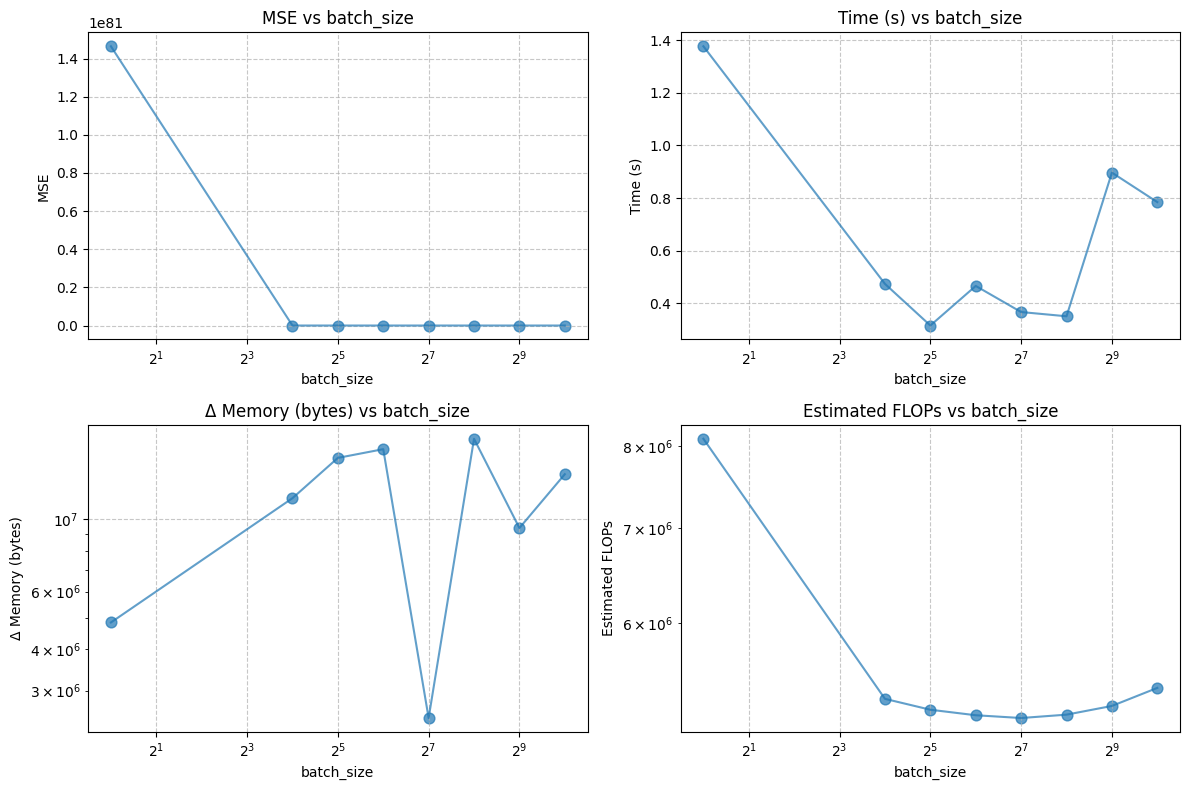

[I 2025-05-21 18:07:08,478] A new study created in memory with name: SGD_reg-elasticnet_lr-0.01_schedule-constant_lambda-0.01


  0%|          | 0/8 [00:00<?, ?it/s]

[I 2025-05-21 18:07:08,917] Trial 2 finished with value: 0.5891017316756578 and parameters: {}. Best is trial 2 with value: 0.5891017316756578.
[I 2025-05-21 18:07:08,947] Trial 1 finished with value: 10473.984842405585 and parameters: {}. Best is trial 2 with value: 0.5891017316756578.
[I 2025-05-21 18:07:08,962] Trial 4 finished with value: 0.5795041668068094 and parameters: {}. Best is trial 4 with value: 0.5795041668068094.
[I 2025-05-21 18:07:08,982] Trial 3 finished with value: 0.567806882235409 and parameters: {}. Best is trial 3 with value: 0.567806882235409.
[I 2025-05-21 18:07:08,984] Trial 5 finished with value: 0.5623466631649696 and parameters: {}. Best is trial 5 with value: 0.5623466631649696.
[I 2025-05-21 18:07:09,398] Trial 7 finished with value: 0.9955180601812998 and parameters: {}. Best is trial 5 with value: 0.5623466631649696.
[I 2025-05-21 18:07:09,408] Trial 6 finished with value: 0.6008783422713485 and parameters: {}. Best is trial 5 with value: 0.562346663164

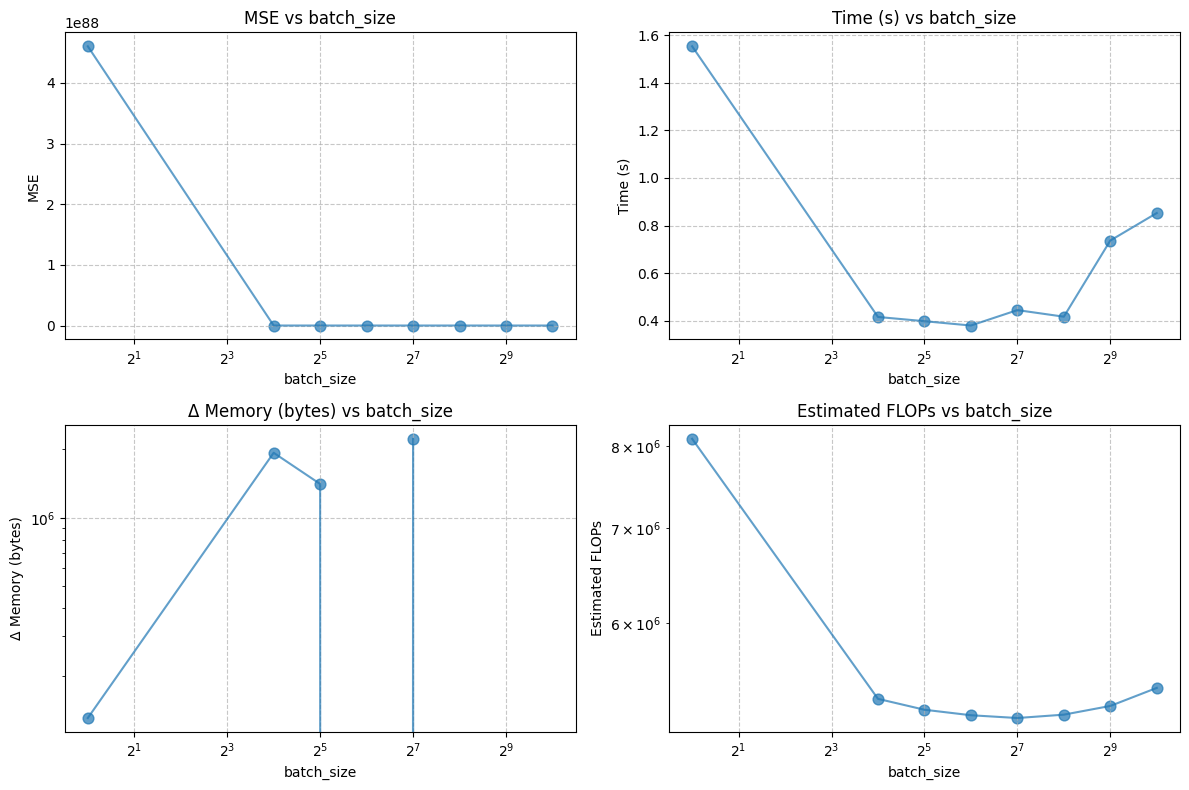

[I 2025-05-21 18:07:11,975] A new study created in memory with name: SGD_reg-elasticnet_lr-0.01_schedule-time_decay_lambda-0.01


  0%|          | 0/8 [00:00<?, ?it/s]

[I 2025-05-21 18:07:12,519] Trial 4 finished with value: 0.5561875559090549 and parameters: {}. Best is trial 4 with value: 0.5561875559090549.
[I 2025-05-21 18:07:12,564] Trial 3 finished with value: 0.5570408517772495 and parameters: {}. Best is trial 4 with value: 0.5561875559090549.
[I 2025-05-21 18:07:12,704] Trial 1 finished with value: 45.80566389627149 and parameters: {}. Best is trial 4 with value: 0.5561875559090549.
[I 2025-05-21 18:07:12,730] Trial 2 finished with value: 0.5543093386910303 and parameters: {}. Best is trial 2 with value: 0.5543093386910303.
[I 2025-05-21 18:07:12,775] Trial 5 finished with value: 0.6477253107130116 and parameters: {}. Best is trial 2 with value: 0.5543093386910303.
[I 2025-05-21 18:07:13,180] Trial 7 finished with value: 0.7794180247365315 and parameters: {}. Best is trial 2 with value: 0.5543093386910303.
[I 2025-05-21 18:07:13,303] Trial 6 finished with value: 0.6462035594891093 and parameters: {}. Best is trial 2 with value: 0.55430933869

/Users/aleksandr/Desktop/itmo/s4/optimisation-methods/Stochastic-Gradient-Descent/src/helpers.py:289: UserWarning: Data has no positive values, and therefore cannot be log-scaled.
  ax.set_yscale("log")


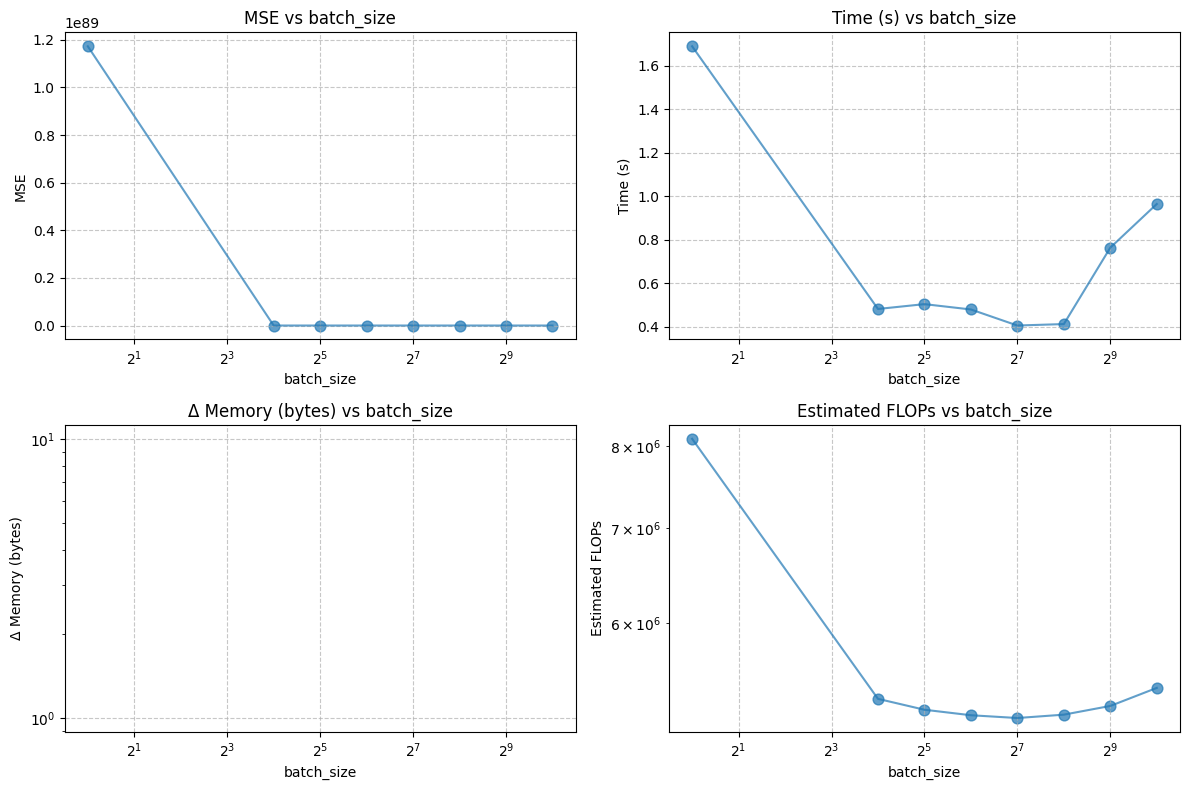

[I 2025-05-21 18:07:15,683] A new study created in memory with name: SGD_reg-elasticnet_lr-0.01_schedule-step_decay_lambda-0.01


  0%|          | 0/8 [00:00<?, ?it/s]

[I 2025-05-21 18:07:16,082] Trial 3 finished with value: 0.550120547819042 and parameters: {}. Best is trial 3 with value: 0.550120547819042.
[I 2025-05-21 18:07:16,158] Trial 5 finished with value: 0.5877780041129125 and parameters: {}. Best is trial 3 with value: 0.550120547819042.
[I 2025-05-21 18:07:16,244] Trial 2 finished with value: 0.5826692132237808 and parameters: {}. Best is trial 3 with value: 0.550120547819042.
[I 2025-05-21 18:07:16,341] Trial 1 finished with value: 79383.54158220624 and parameters: {}. Best is trial 3 with value: 0.550120547819042.
[I 2025-05-21 18:07:16,347] Trial 4 finished with value: 0.5646934302121593 and parameters: {}. Best is trial 3 with value: 0.550120547819042.
[I 2025-05-21 18:07:16,784] Trial 6 finished with value: 0.774279736111091 and parameters: {}. Best is trial 3 with value: 0.550120547819042.
[I 2025-05-21 18:07:16,798] Trial 7 finished with value: 0.8766745461037091 and parameters: {}. Best is trial 3 with value: 0.550120547819042.
[I

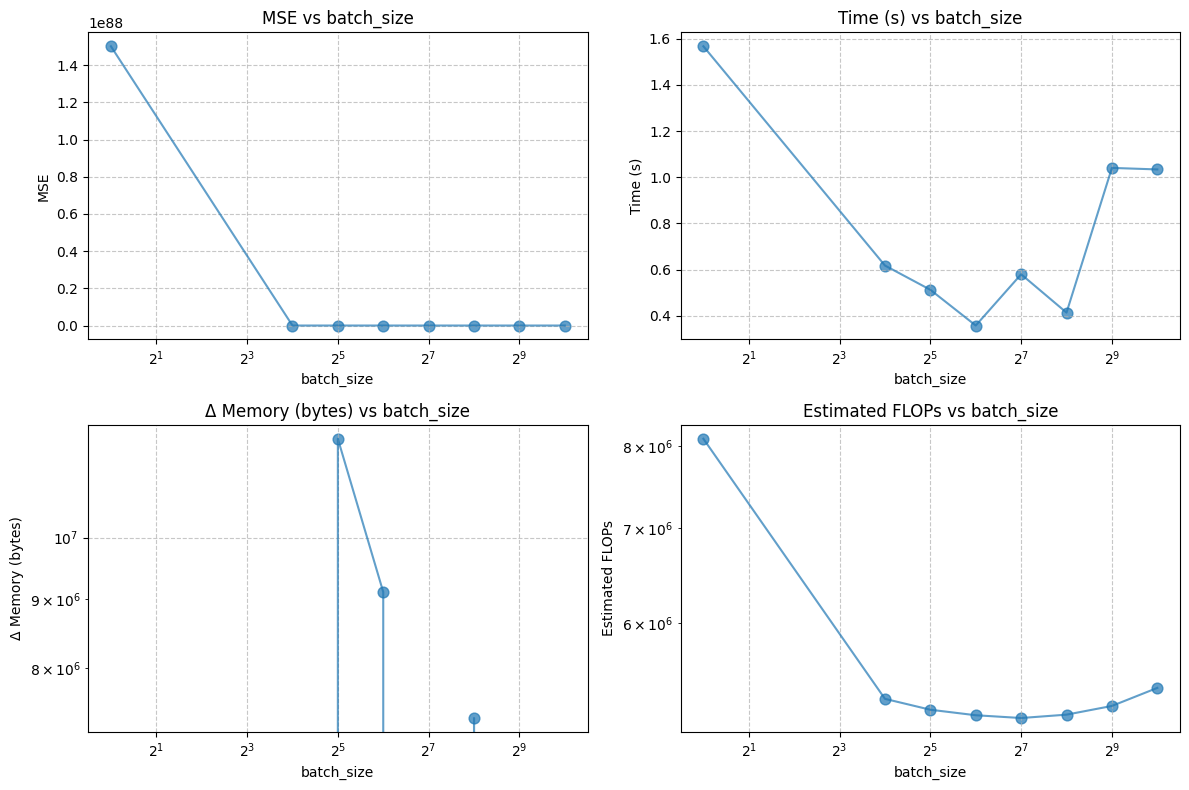

[I 2025-05-21 18:07:19,252] A new study created in memory with name: SGD_reg-elasticnet_lr-0.01_schedule-exponential_lambda-0.01


  0%|          | 0/8 [00:00<?, ?it/s]

[I 2025-05-21 18:07:19,752] Trial 2 finished with value: 0.5531894207729594 and parameters: {}. Best is trial 2 with value: 0.5531894207729594.
[I 2025-05-21 18:07:19,761] Trial 1 finished with value: 59.406934094087816 and parameters: {}. Best is trial 2 with value: 0.5531894207729594.
[I 2025-05-21 18:07:19,794] Trial 3 finished with value: 0.5551312568233492 and parameters: {}. Best is trial 2 with value: 0.5531894207729594.
[I 2025-05-21 18:07:19,810] Trial 4 finished with value: 0.5862156883221548 and parameters: {}. Best is trial 2 with value: 0.5531894207729594.
[I 2025-05-21 18:07:19,893] Trial 5 finished with value: 0.5627179910547169 and parameters: {}. Best is trial 2 with value: 0.5531894207729594.
[I 2025-05-21 18:07:20,249] Trial 7 finished with value: 0.8971596742485752 and parameters: {}. Best is trial 2 with value: 0.5531894207729594.
[I 2025-05-21 18:07:20,288] Trial 6 finished with value: 0.7173894733434496 and parameters: {}. Best is trial 2 with value: 0.5531894207

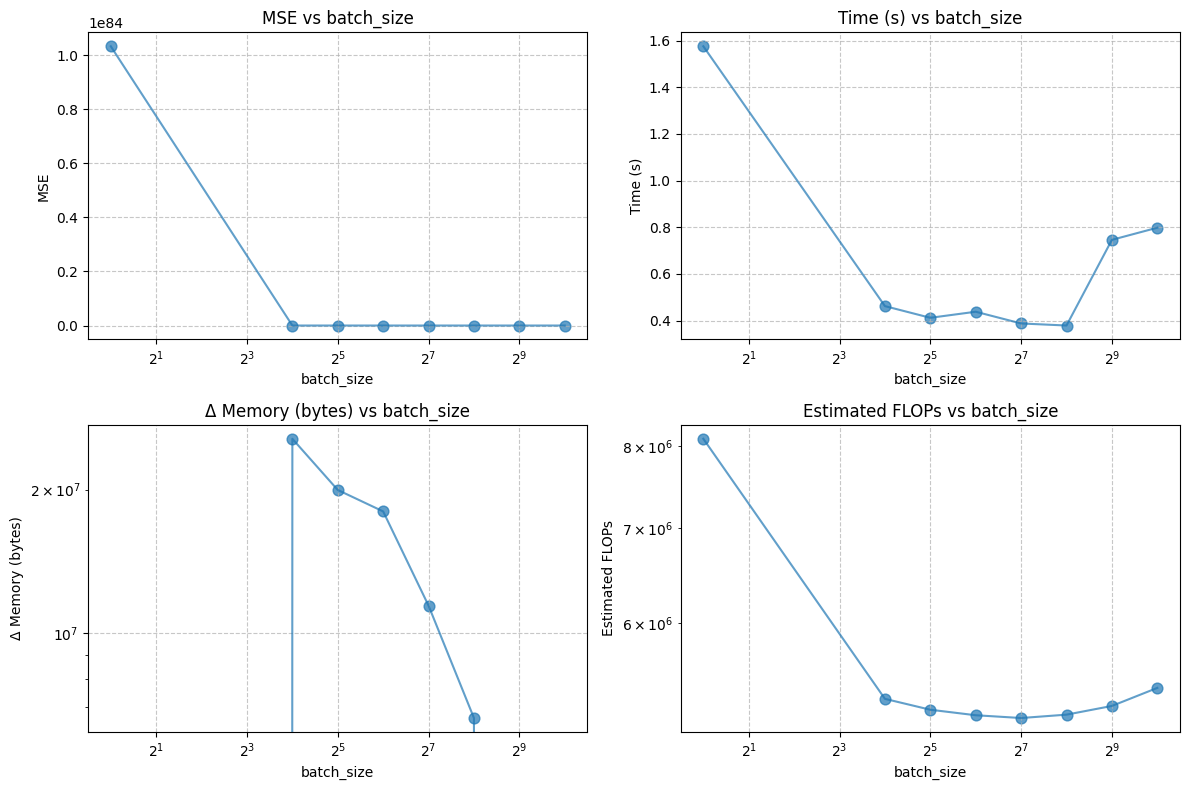

In [3]:
def bench(reg, lrs):
    models = []
    for batch_size in [1, 16, 32, 64, 128, 256, 512, 1024]:
        X, y = load_california(scale=True)
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

        model = SGD(
            learning_rate=0.01,
            epochs=10,
            batch_size=batch_size,
            regularization=reg,
            reg_param=0.01,
            lr_schedule=lrs
        )
        model.fit(X_train, y_train)
        models.append(model)

    plot_performance_metrics(models)

for reg in ['l1', 'l2', 'elasticnet']:
    for lrs in ['constant', 'time_decay', 'step_decay', 'exponential']:
        bench(reg, lrs)